<a href="https://colab.research.google.com/github/blufzzz/Introspective-Neural-Networks/blob/master/training_wasserstein.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# from google.colab import drive
# drive.mount('./gdrive')

In [0]:
# cd ./gdrive/My\ Drive/Colab Notebooks/Introspective-Neural-Networks-master

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader
from torch.cuda import set_device
from tqdm import tnrange, tqdm_notebook

from synthesis import Synthesis
from utils import MnistDataset, get_data_loaders, calculate_metric, print_scores
from models import MnistResNet

/opt/conda/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


# Wasserstein loss

In [0]:
def train(model, train_loader, val_loader, epochs=1, alpha=0.9):

    '''
    It's Yaroslav train func
    Add Wass. loss and other necessary stuff here
    Use MnistResNet for training
    '''
    def wasserstein_loss(model, X, fakes, batch_size = 100, lam = 10):
        X_1 = X[1-fakes]
        X_2 = X[fakes]
        batch_1 = X_1[torch.LongTensor(batch_size).random_(len(X_1))]
        batch_2 = X_2[torch.LongTensor(batch_size).random_(len(X_2))]
        a = torch.rand_like(batch_1[:, 0]).unsqueeze(1)
        batch_hat = (a * batch_1.data + (1-a) * batch_2.data).requires_grad_(True)
        f_1 = model(batch_1)
        f_2 = model(batch_2)
        f_hat = model(batch_hat)
        init = torch.ones_like(f_hat)
        grads_hat = torch.autograd.grad(f_hat, batch_hat, grad_outputs=init, only_inputs=True, create_graph=True, retain_graph=True)[0]
        loss = f_2.mean() - f_1.mean() + lam*((grads_hat.norm(2, dim=1) - 1) ** 2).mean()
        return loss
        
    start_ts = time.time()

    losses = []
    
    loss_function = nn.CrossEntropyLoss()
    
    #optimizer = optim.Adadelta(model.parameters())
    optimizer = optim.Adam(model.parameters(), amsgrad=True)
    #optimizer = optim.SGD(model.parameters(), lr=1e-2);

    batches = len(train_loader)
    val_batches = len(val_loader)

    # training loop + eval loop
    for epoch in range(epochs):
        total_loss = 0
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)
        model.train()

        for i, data in progress:
            X, y, fakes = data[0].cuda(), data[1].cuda().squeeze(-1).long(), data[2].cuda()
            
            model.zero_grad()
            
            outputs = model(X)
            
            loss = loss_function(outputs[1-fakes], y[1-fakes])
            if not torch.all(fakes == 0):
                loss += 0.01*wasserstein_loss(model, X, fakes)
            
            #if not torch.all(fakes == 0):
            #    mask = torch.zeros((y.shape[0], 10)).byte();
            #    for i in range(y.shape[0]):
            #        mask[i, y[i]] = 1;
                    
            #    loss += alpha*torch.sum(torch.log1p(torch.exp(outputs[mask][fakes])));
            loss.backward()
            optimizer.step()
            progress.set_description("Loss: {:.4f}".format(loss.item()))

        torch.cuda.empty_cache()

        val_losses = 0
        precision, recall, f1, accuracy = [], [], [], []

        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                X, y = data[0].cuda(), data[1].cuda().squeeze(-1)
                outputs = torch.sigmoid(model(X))
                #val_losses += nn.CrossEntropyLoss(outputs, y.long())
                val_losses += loss_function(outputs, y.long())

                predicted_classes = torch.max(outputs, 1)[1]

                for acc, metric in zip((precision, recall, f1, accuracy), 
                                       (precision_score, recall_score, f1_score, accuracy_score)):
                    acc.append(
                        calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                    )


        print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
        print_scores(precision, recall, f1, accuracy, val_batches)
        losses.append(total_loss/batches)
    pass

In [0]:
l = 2
tmax = 5;
train_loader, val_loader = get_data_loaders(256, 256, download = True);
for t in range(tmax):
    model = MnistResNet().cuda();
    train(model, train_loader, val_loader, alpha=0.1);
    
    s = Synthesis(init_std=0.3)
    for i in range(l):
        aug = s.sample(model, num_iter=50, learning_rate=1e-1, add_noise=True);
        
        for i in range(aug.shape[0]):
            aug[i,...] -= aug[i, ...].min();
            aug[i, ...] /= aug[i, ...].max();
        
        train_loader.dataset.add_artificial(aug);


Epoch 1/1, training loss: 0.0, validation loss: 1.5676023960113525
	     precision: 0.9865
	        recall: 0.9864
	            F1: 0.9860
	      accuracy: 0.9862



Epoch 1/1, training loss: 0.0, validation loss: 1.5730775594711304
	     precision: 0.9855
	        recall: 0.9851
	            F1: 0.9849
	      accuracy: 0.9851



Epoch 1/1, training loss: 0.0, validation loss: 1.5665748119354248
	     precision: 0.9903
	        recall: 0.9909
	            F1: 0.9903
	      accuracy: 0.9906


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 1/1, training loss: 0.0, validation loss: 1.5841120481491089
	     precision: 0.9728
	        recall: 0.9732
	            F1: 0.9719
	      accuracy: 0.9744



Epoch 1/1, training loss: 0.0, validation loss: 1.5967167615890503
	     precision: 0.9838
	        recall: 0.9830
	            F1: 0.9827
	      accuracy: 0.9830


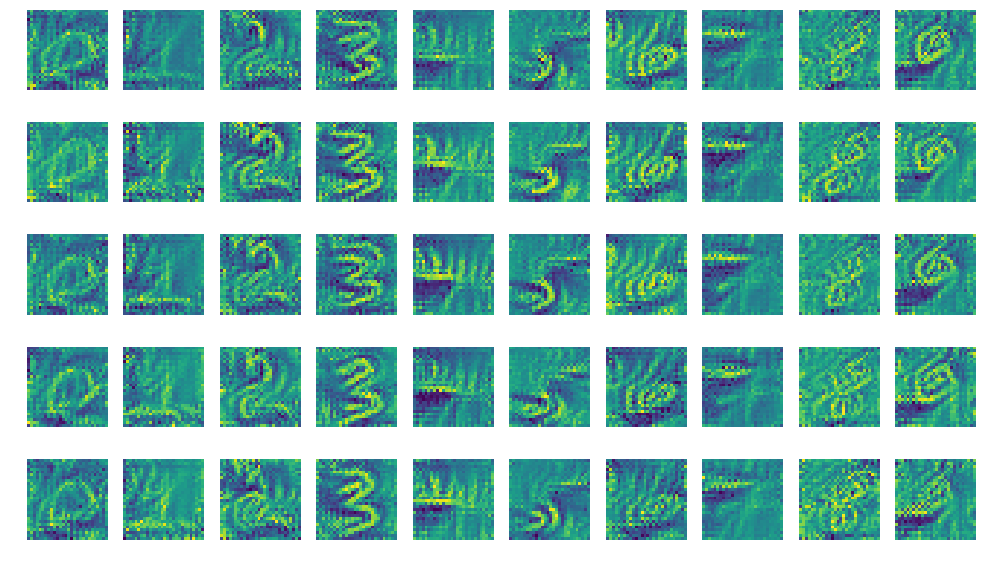

In [0]:
fig,ax = plt.subplots(nrows=5, ncols=10, figsize=(17,10));
for j in range(5):
    s = Synthesis(init_std=0.3)
    aug = s.sample(model, num_iter=50, learning_rate=1e-1, add_noise=True);
    for i in range(aug.shape[0]):
            aug[i,...] -= aug[i, ...].min();
            aug[i, ...] /= aug[i, ...].max();
    for i in range(10):
        ax[j][i].imshow(aug[i,0,...].cpu());
        ax[j][i].axis('off');

In [0]:
l = 20
tmax = 35;
train_loader, val_loader = get_data_loaders(256, 256, download = True);
for t in range(tmax):
    model = MnistResNet().cuda();
    train(model, train_loader, val_loader, alpha=0.1);
    
    s = Synthesis(init_std=0.3)
    for i in range(l):
        aug = s.sample(model, num_iter=50, learning_rate=1e-1, add_noise=True);
        
        for i in range(aug.shape[0]):
            aug[i,...] -= aug[i, ...].min();
            aug[i, ...] /= aug[i, ...].max();
        
        train_loader.dataset.add_artificial(aug);


Epoch 1/1, training loss: 0.0, validation loss: 1.5702213048934937
	     precision: 0.9893
	        recall: 0.9893
	            F1: 0.9890
	      accuracy: 0.9893



Epoch 1/1, training loss: 0.0, validation loss: 1.582661509513855
	     precision: 0.9832
	        recall: 0.9831
	            F1: 0.9825
	      accuracy: 0.9829



Epoch 1/1, training loss: 0.0, validation loss: 2.1041109561920166
	     precision: 0.2467
	        recall: 0.2726
	            F1: 0.1641
	      accuracy: 0.2663



Epoch 1/1, training loss: 0.0, validation loss: 1.7167125940322876
	     precision: 0.8874
	        recall: 0.8566
	            F1: 0.8509
	      accuracy: 0.8521



Epoch 1/1, training loss: 0.0, validation loss: 1.5980230569839478
	     precision: 0.9234
	        recall: 0.9088
	            F1: 0.9044
	      accuracy: 0.9092



Epoch 1/1, training loss: 0.0, validation loss: 1.5529839992523193
	     precision: 0.9652
	        recall: 0.9611
	            F1: 0.9610
	      accuracy: 0.9615



Epoch 1/1, training loss: 0.0, validation loss: 1.516045331954956
	     precision: 0.9725
	        recall: 0.9711
	            F1: 0.9704
	      accuracy: 0.9713



Epoch 1/1, training loss: 0.0, validation loss: 1.5350347757339478
	     precision: 0.9607
	        recall: 0.9594
	            F1: 0.9581
	      accuracy: 0.9597



Epoch 1/1, training loss: 0.0, validation loss: 1.5194400548934937
	     precision: 0.9798
	        recall: 0.9797
	            F1: 0.9791
	      accuracy: 0.9796



Epoch 1/1, training loss: 0.0, validation loss: 1.587844729423523
	     precision: 0.9295
	        recall: 0.9111
	            F1: 0.9096
	      accuracy: 0.9093



Epoch 1/1, training loss: 0.0, validation loss: 1.623885154724121
	     precision: 0.8814
	        recall: 0.8583
	            F1: 0.8371
	      accuracy: 0.8496



Epoch 1/1, training loss: 0.0, validation loss: 1.5666388273239136
	     precision: 0.9360
	        recall: 0.9248
	            F1: 0.9221
	      accuracy: 0.9232



Epoch 1/1, training loss: 0.0, validation loss: 1.601807951927185
	     precision: 0.9176
	        recall: 0.9051
	            F1: 0.8920
	      accuracy: 0.8987



Epoch 1/1, training loss: 0.0, validation loss: 1.5147638320922852
	     precision: 0.9736
	        recall: 0.9706
	            F1: 0.9706
	      accuracy: 0.9710



Epoch 1/1, training loss: 0.0, validation loss: 1.6459413766860962
	     precision: 0.9047
	        recall: 0.8303
	            F1: 0.8321
	      accuracy: 0.8311



Epoch 1/1, training loss: 0.0, validation loss: 1.5591685771942139
	     precision: 0.9345
	        recall: 0.9256
	            F1: 0.9146
	      accuracy: 0.9189



Epoch 1/1, training loss: 0.0, validation loss: 1.711019515991211
	     precision: 0.7753
	        recall: 0.7801
	            F1: 0.7509
	      accuracy: 0.7690



Epoch 1/1, training loss: 0.0, validation loss: 1.570089340209961
	     precision: 0.9354
	        recall: 0.9239
	            F1: 0.9222
	      accuracy: 0.9232



Epoch 1/1, training loss: 0.0, validation loss: 1.5304301977157593
	     precision: 0.9506
	        recall: 0.9429
	            F1: 0.9411
	      accuracy: 0.9437



Epoch 1/1, training loss: 0.0, validation loss: 1.570673942565918
	     precision: 0.9294
	        recall: 0.9255
	            F1: 0.9236
	      accuracy: 0.9261



Epoch 1/1, training loss: 0.0, validation loss: 1.5283808708190918
	     precision: 0.9681
	        recall: 0.9671
	            F1: 0.9657
	      accuracy: 0.9657



Epoch 1/1, training loss: 0.0, validation loss: 1.5883185863494873
	     precision: 0.9407
	        recall: 0.9347
	            F1: 0.9298
	      accuracy: 0.9313



Epoch 1/1, training loss: 0.0, validation loss: 1.7118781805038452
	     precision: 0.7860
	        recall: 0.8078
	            F1: 0.7725
	      accuracy: 0.7959



Epoch 1/1, training loss: 0.0, validation loss: 1.547627329826355
	     precision: 0.9483
	        recall: 0.9396
	            F1: 0.9390
	      accuracy: 0.9382



Epoch 1/1, training loss: 0.0, validation loss: 1.525638461112976
	     precision: 0.9627
	        recall: 0.9580
	            F1: 0.9578
	      accuracy: 0.9591



Epoch 1/1, training loss: 0.0, validation loss: 1.5838074684143066
	     precision: 0.9021
	        recall: 0.8791
	            F1: 0.8679
	      accuracy: 0.8809



Epoch 1/1, training loss: 0.0, validation loss: 1.6192611455917358
	     precision: 0.8884
	        recall: 0.8285
	            F1: 0.8243
	      accuracy: 0.8294



Epoch 1/1, training loss: 0.0, validation loss: 1.554924488067627
	     precision: 0.9602
	        recall: 0.9580
	            F1: 0.9564
	      accuracy: 0.9571



Epoch 1/1, training loss: 0.0, validation loss: 1.708086609840393
	     precision: 0.8776
	        recall: 0.7914
	            F1: 0.7854
	      accuracy: 0.7954



Epoch 1/1, training loss: 0.0, validation loss: 1.7198606729507446
	     precision: 0.8543
	        recall: 0.7663
	            F1: 0.7534
	      accuracy: 0.7671



Epoch 1/1, training loss: 0.0, validation loss: 1.7590572834014893
	     precision: 0.8120
	        recall: 0.6689
	            F1: 0.6561
	      accuracy: 0.6747



Epoch 1/1, training loss: 0.0, validation loss: 1.5245468616485596
	     precision: 0.9475
	        recall: 0.9392
	            F1: 0.9371
	      accuracy: 0.9402



Epoch 1/1, training loss: 0.0, validation loss: 1.493648648262024
	     precision: 0.9762
	        recall: 0.9750
	            F1: 0.9747
	      accuracy: 0.9754



Epoch 1/1, training loss: 0.0, validation loss: 1.5049784183502197
	     precision: 0.9785
	        recall: 0.9782
	            F1: 0.9775
	      accuracy: 0.9780



Epoch 1/1, training loss: 0.0, validation loss: 1.5186418294906616
	     precision: 0.9784
	        recall: 0.9780
	            F1: 0.9773
	      accuracy: 0.9778


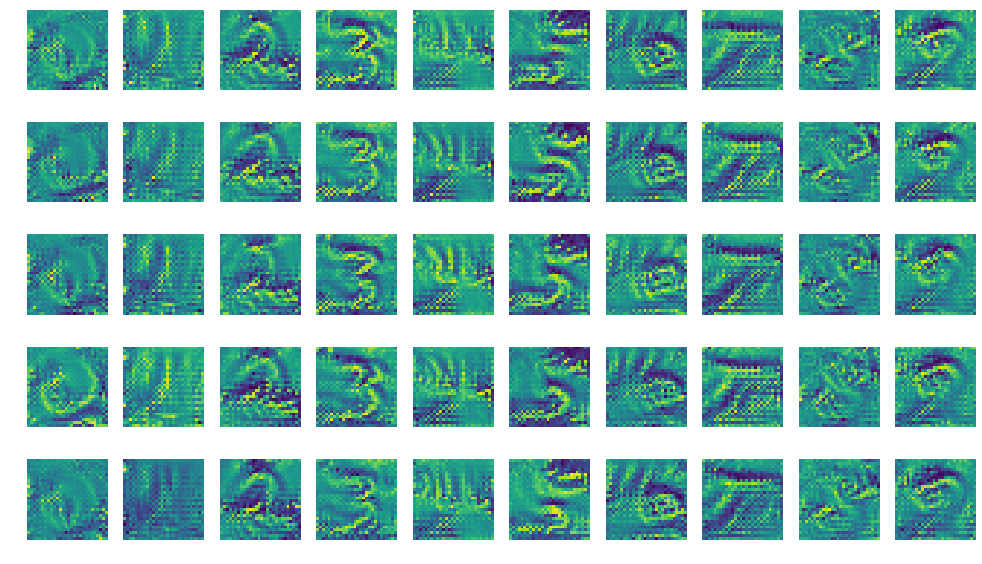

In [0]:
fig,ax = plt.subplots(nrows=5, ncols=10, figsize=(17,10));
for j in range(5):
    s = Synthesis(init_std=0.3)
    aug = s.sample(model, num_iter=50, learning_rate=1e-1, add_noise=True);
    for i in range(aug.shape[0]):
            aug[i,...] -= aug[i, ...].min();
            aug[i, ...] /= aug[i, ...].max();
    for i in range(10):
        ax[j][i].imshow(aug[i,0,...].cpu());
        ax[j][i].axis('off');

In [0]:
l = 2
tmax = 15;
train_loader, val_loader = get_data_loaders(256, 256, download = True);
for t in range(tmax):
    model = MnistResNet().cuda();
    train(model, train_loader, val_loader, alpha=0.1);
    
    s = Synthesis(init_std=0.3)
    for i in range(l):
        aug = s.sample(model, num_iter=50, learning_rate=1e-1, add_noise=True);
        
        for i in range(aug.shape[0]):
            aug[i,...] -= aug[i, ...].min();
            aug[i, ...] /= aug[i, ...].max();
        
        train_loader.dataset.add_artificial(aug);


Epoch 1/1, training loss: 0.0, validation loss: 1.5735596418380737
	     precision: 0.9851
	        recall: 0.9853
	            F1: 0.9848
	      accuracy: 0.9852



Epoch 1/1, training loss: 0.0, validation loss: 1.5838056802749634
	     precision: 0.9848
	        recall: 0.9849
	            F1: 0.9844
	      accuracy: 0.9849



Epoch 1/1, training loss: 0.0, validation loss: 1.575496792793274
	     precision: 0.9887
	        recall: 0.9891
	            F1: 0.9886
	      accuracy: 0.9889



Epoch 1/1, training loss: 0.0, validation loss: 1.574857473373413
	     precision: 0.9856
	        recall: 0.9854
	            F1: 0.9851
	      accuracy: 0.9858



Epoch 1/1, training loss: 0.0, validation loss: 1.565489649772644
	     precision: 0.9867
	        recall: 0.9866
	            F1: 0.9862
	      accuracy: 0.9866



Epoch 1/1, training loss: 0.0, validation loss: 1.5915805101394653
	     precision: 0.9814
	        recall: 0.9810
	            F1: 0.9806
	      accuracy: 0.9809



Epoch 1/1, training loss: 0.0, validation loss: 1.5933464765548706
	     precision: 0.9860
	        recall: 0.9860
	            F1: 0.9855
	      accuracy: 0.9857



Epoch 1/1, training loss: 0.0, validation loss: 1.5763882398605347
	     precision: 0.9813
	        recall: 0.9810
	            F1: 0.9805
	      accuracy: 0.9810



Epoch 1/1, training loss: 0.0, validation loss: 1.6110038757324219
	     precision: 0.9613
	        recall: 0.9512
	            F1: 0.9521
	      accuracy: 0.9518



Epoch 1/1, training loss: 0.0, validation loss: 1.5726827383041382
	     precision: 0.9873
	        recall: 0.9872
	            F1: 0.9869
	      accuracy: 0.9873



Epoch 1/1, training loss: 0.0, validation loss: 1.659039855003357
	     precision: 0.8955
	        recall: 0.8381
	            F1: 0.8318
	      accuracy: 0.8429



Epoch 1/1, training loss: 0.0, validation loss: 1.5837382078170776
	     precision: 0.9649
	        recall: 0.9622
	            F1: 0.9614
	      accuracy: 0.9626



Epoch 1/1, training loss: 0.0, validation loss: 1.547206997871399
	     precision: 0.9907
	        recall: 0.9910
	            F1: 0.9907
	      accuracy: 0.9908



Epoch 1/1, training loss: 0.0, validation loss: 1.5880415439605713
	     precision: 0.9566
	        recall: 0.9500
	            F1: 0.9498
	      accuracy: 0.9505



Epoch 1/1, training loss: 0.0, validation loss: 1.5840390920639038
	     precision: 0.9558
	        recall: 0.9496
	            F1: 0.9470
	      accuracy: 0.9471


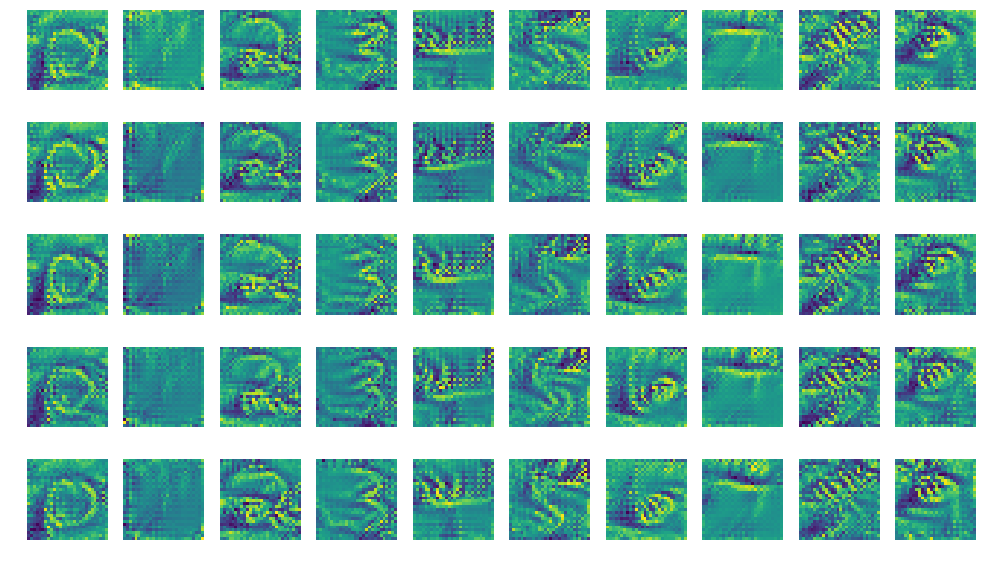

In [0]:
fig,ax = plt.subplots(nrows=5, ncols=10, figsize=(17,10));
for j in range(5):
    s = Synthesis(init_std=0.3)
    aug = s.sample(model, num_iter=50, learning_rate=1e-1, add_noise=True);
    for i in range(aug.shape[0]):
            aug[i,...] -= aug[i, ...].min();
            aug[i, ...] /= aug[i, ...].max();
    for i in range(10):
        ax[j][i].imshow(aug[i,0,...].cpu());
        ax[j][i].axis('off');